### DETECTION OF ACUTE LYMPHOBLASTIC LEUKEMIA

IMPORT

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import os
import tqdm
import skimage.io
import glob

from tqdm import tqdm

from skimage.io import imread, imshow

from skimage.transform import resize

from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Instantiating the model for loading the weights and biases and preprocess

In [3]:
# Instantiating the model for loading the weights and biases and preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

%matplotlib inline

In [4]:
pwd


'C:\\Users\\GAGANASRI\\Downloads'

TRAINING DATA PREPROCESSING 

In [5]:
train_dataset_0_all = glob.glob('C:/Users/GAGANASRI/Downloads/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')


In [6]:
train_dataset_0_hem = glob.glob('C:/Users/GAGANASRI/Downloads/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob('C:/Users/GAGANASRI/Downloads/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob('C:/Users/GAGANASRI/Downloads/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob('C:/Users/GAGANASRI/Downloads/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob('C:/Users/GAGANASRI/Downloads/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

In [7]:
valid_data    = pd.read_csv('C:/Users/GAGANASRI/Downloads/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

In [8]:
A= []
H = []

A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)
A.extend(train_dataset_2_all)

H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
H.extend(train_dataset_2_hem)

A = np.array(A)
H = np.array(H)

len(A),len(H)

(7272, 3389)

In [9]:
Image = []
Label = []

for i in tqdm(range(0, len(A))):
    img = imread(A[i])
    img = resize(img, (128,128))
    Image.append(img)
    Label.append(1)
    
for i in tqdm(range(0, len(H))):
    img = imread(H[i])
    img = resize(img, (128,128))
    Image.append(img)
    Label.append(0)
    
Image = np.array(Image)
Label = np.array(Label)

Image.shape, Label.shape

100%|██████████| 3389/3389 [01:29<00:00, 37.93it/s]


((10661, 128, 128, 3), (10661,))

In [10]:
Image, Label = shuffle(Image, Label, random_state = 42)

100%|██████████| 5/5 [00:00<00:00,  9.60it/s]


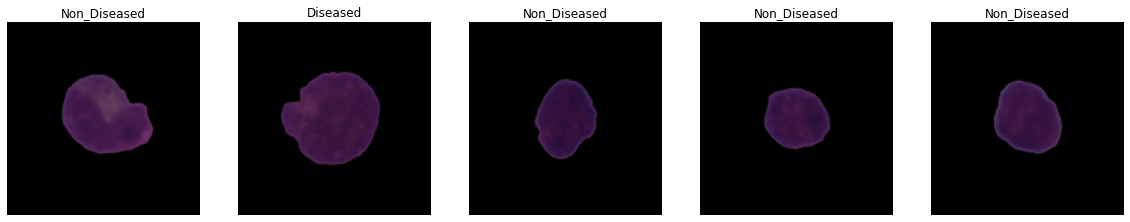

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Diseased')
    else:
        ax[i].set_title('Non_Diseased')

In [12]:
X = Image
y = Label

In [13]:
del Image
del Label
del A
del H

VALIDATION DATA PREPROCESSING

In [14]:
valid_data.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [ ]:
valid_data.labels.value_counts()

In [15]:
X_val = []

for image_name in valid_data.new_names:
    # Loading images
    img = imread('C:/Users/GAGANASRI/Downloads/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/' + image_name)
    # Resizing 
    img = resize(img, (128,128))
    # Appending them into list
    X_val.append(img)
 # Converting into array
X_val = np.array(X_val)

# Storing target values as well 
y_val = valid_data.labels.values

## DATA AUGMENTATION 

TRAINING DATA

In [16]:
train_datagen  = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    zoom_range = 0.2,
                                    preprocessing_function=preprocess_input)
train_datagen.fit(X)

VALIDATION DATA

In [17]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_datagen.fit(X_val)

## MODEL BUILDING 

PRETRAINED MODEL WITH IMAGE NET WEIGHTS

In [18]:
#INCEPTION MODEL 
incep_v3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(128,128,3))

In [19]:
incep_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
for layers in incep_v3.layers:
    layers.trainable = False
    
x = Flatten()(incep_v3.output)


## ClassificatioN

In [21]:
#Fully connected layers (fcc)
fcc_layer_1 = Dense(units = 1024, activation = 'relu')(x)
dropout_1   = Dropout(0.3)(fcc_layer_1)

fcc_layer_2 = Dense(units = 512, activation = 'relu')(dropout_1)
dropout_2   = Dropout(0.3)(fcc_layer_2)

final_layer = Dense(units = 1, activation = 'sigmoid')(dropout_2)

In [22]:

model = Model(inputs = incep_v3.input, outputs = final_layer)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

COMPILING WITH HYPER PARAMETERS

In [24]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [25]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                  mode = 'max',
                                  patience = 5,
                                  factor = 0.3,
                                  min_delta = 0.00001)


callback_list = [earlystopping, checkpoint, learning_rate]

In [ ]:
model_history = model.fit(train_datagen.flow(X, y, batch_size=512), 
                          validation_data = (X_val, y_val),
                          epochs = 500,
                          verbose = 1,
                          callbacks = callback_list)


  ...
    to  
  ['...']
Train for 21 steps, validate on 1867 samples
Epoch 1/500
20/21 [===========================>..] - ETA: 17s - loss: 1.2454 - accuracy: 0.6141
Epoch 00001: val_accuracy improved from -inf to 0.65292, saving model to ./best_weights.hdf5
21/21 [==============================] - 396s 19s/step - loss: 1.2164 - accuracy: 0.6152 - val_loss: 1.0538 - val_accuracy: 0.6529
Epoch 2/500
20/21 [===========================>..] - ETA: 15s - loss: 0.5800 - accuracy: 0.7218
Epoch 00002: val_accuracy did not improve from 0.65292
21/21 [==============================] - 353s 17s/step - loss: 0.5763 - accuracy: 0.7251 - val_loss: 0.8931 - val_accuracy: 0.4413
Epoch 3/500
20/21 [===========================>..] - ETA: 16s - loss: 0.5138 - accuracy: 0.7669
Epoch 00003: val_accuracy did not improve from 0.65292
21/21 [==============================] - 370s 18s/step - loss: 0.5122 - accuracy: 0.7685 - val_loss: 0.9350 - val_accuracy: 0.4467
Epoch 4/500
20/21 [===========================

The number of epochs are to be stopped at 16.BUt due to laptop crash , it has not been saved .
EXplanation :
After 11 epochs the code runs till 16 epochs and stops due to no improvement in the valudation accuracy.And gives an output of early stopping .

extra codes with test data and different classifier

## 

In [ ]:
# extract features  
features = model.predict(x) 

In [ ]:

def plot_training_history(model_history, model):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()
    
    loss, accuracy  = model.evaluate(test_data, test_labels, verbose=False)
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')






#to check for different drop rates
dropout_rates = [.8, .5, .3, .2, .1]

for dropout_rate in dropout_rates:
    model = Model(inputs = incep_v3.input, outputs = final_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_history = model.fit(train_datagen.flow(X, y, batch_size=512), 
                          validation_data = (X_val, y_val),
                          epochs = 500,
                          verbose = 1,
                          callbacks = callback_list)

    print(f'\ndropout_rate: {dropout_rate}')
    plot_training_history(model_history, model)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

dtree.fit(X_train,y_train)

predictions = dtree.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predictions))

In [ ]:
predictions = logmodel.predict(X_test)


from sklearn.metrics import classification_report,confusion_matrix


print(classification_report(y_test,predictions))



print(confusion_matrix(y_test,predictions))

In [ ]:
## 
predictions = model.predict(conv_test_data)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1))
plt.figure(figsize = (15, 15))

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()